20.07.2019 al 31.07.2019

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from numpy.random import seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
import tools
from datetime import datetime
import tensorflow


In [2]:
df_1 = pd.read_csv(r'..\data\untouched_data\oli\2018\HPDIC059.csv', sep=';')
df_2 = pd.read_csv(r'..\data\untouched_data\oli\2018\HPI884.csv', sep=';')
df_3 = pd.read_csv(r'..\data\untouched_data\oli\2018\HTI878.csv', sep=';')
df_4 = pd.read_csv(r'..\data\untouched_data\oli\2018\HTI893.csv', sep=';')
df_1['Time'] = pd.to_datetime(df_1['Time'], format=tools.date_format)
df_2['Time'] = pd.to_datetime(df_2['Time'], format=tools.date_format)
df_3['Time'] = pd.to_datetime(df_3['Time'], format=tools.date_format)
df_4['Time'] = pd.to_datetime(df_4['Time'], format=tools.date_format)
splits = ['01/06/2019','01/07/2019','01/08/2019']
d_1 = datetime.strptime(splits[0], "%d/%m/%Y")
d_2 = datetime.strptime(splits[2], "%d/%m/%Y")
df_1 = df_1.set_index('Time').sort_index()[d_1:d_2]
df_2 = df_2.set_index('Time').sort_index()[d_1:d_2]
df_3 = df_3.set_index('Time').sort_index()[d_1:d_2]
df_4 = df_4.set_index('Time').sort_index()[d_1:d_2]

In [3]:
df_list = [df_1, df_2, df_3, df_4]
dataset_train, dataset_test = tools.init_datasets_prepared(df_list, splits,resample=False, resample_time='5Min')
X_train, X_test = tools.scale_base(dataset_train, dataset_test)

Train starts at 2019-06-01 00:57:07 and ends at 2019-06-30 22:09:15
Test starts at 2019-07-01 00:09:07 and ends at 2019-07-31 23:30:50


In [4]:
seed(10)
tensorflow.random.set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [5]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Epoch 1/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2201 - val_loss: 0.1153
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0876 - val_loss: 0.0325
Epoch 3/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0250
Epoch 4/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0262
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0241
Epoch 6/100
35/35 [==============================] - 0s 1000us/step - loss: 0.0201 - val_loss: 0.0206
Epoch 7/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0184 - val_loss: 0.0177
Epoch 8/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0169 - val_loss: 0.0149
Epoch 9/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0154 - val_loss: 0.0134
Epoch 10/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0093
Epoch 

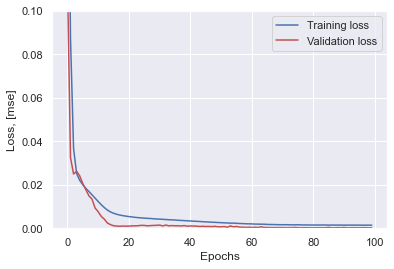

In [6]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

<Figure size 432x288 with 0 Axes>

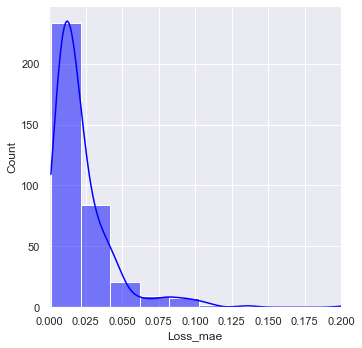

In [7]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.displot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue')
_ = plt.xlim([0.0,.2])

In [8]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
#scored['Threshold'] = 0.3
#scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae
Time,
2019-07-01 00:09:07,0.023612
2019-07-01 02:08:59,0.008355
2019-07-01 04:08:51,0.006834
2019-07-01 06:08:43,0.018777
2019-07-01 08:08:35,0.019571


In [9]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
#scored_train['Threshold'] = 0.3
#scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

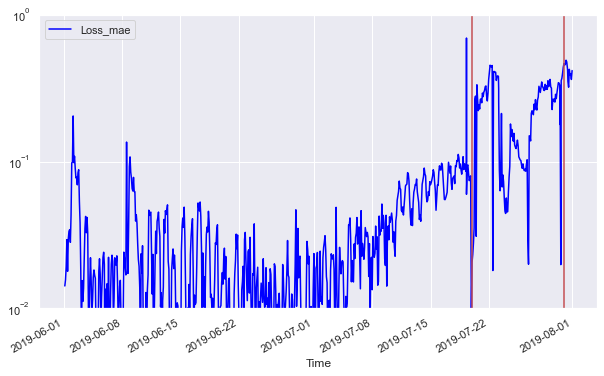

In [12]:
_  = scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e0], color = ['blue','red'])
_ = plt.axvline(datetime(2019, 7, 20), color='r')
_ = plt.axvline(datetime(2019, 7, 31), color='r')

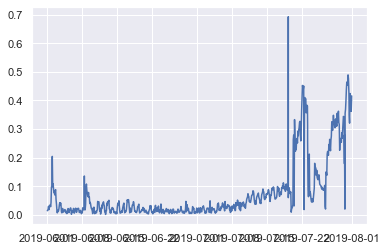

In [13]:
plt.plot(scored['Loss_mae'])

In [16]:
scored

,Loss_mae,Threshold,Anomaly
Time,,,
2019-06-01 02:56:59,0.014214,0.3,False
2019-06-01 04:56:51,0.015653,0.3,False
2019-06-01 06:56:43,0.019318,0.3,False
2019-06-01 08:56:35,0.029366,0.3,False
2019-06-01 10:56:27,0.017881,0.3,False
...,...,...,...
2019-07-31 15:31:22,0.424210,0.3,True
2019-07-31 17:31:14,0.387777,0.3,True
2019-07-31 19:31:06,0.394270,0.3,True


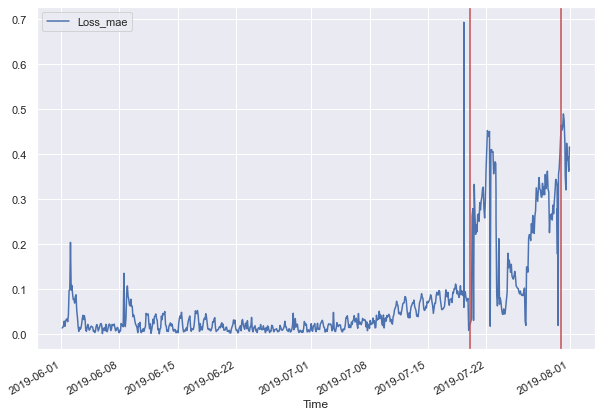

In [20]:
import datetime as dt
f,ax=plt.subplots(figsize=(10,7))
scored.rolling(window=1,center=True).median().plot(ax=ax)
plt.axvline(dt.datetime(2019, 7, 20), color='r')
plt.axvline(dt.datetime(2019, 7, 31), color='r')